In [1]:
from __future__ import print_function 
import os, sys, h5py
import numpy as np
from six.moves import cPickle
from collections import OrderedDict

import tensorflow as tf
sys.path.append('..')
from tfomics import neuralnetwork as nn
from tfomics import utils, fit, init, visualize, saliency
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
def load_RNAcompete_dataset(filepath, split_ratio=0.9):
    trainmat = h5py.File(filepath, 'r')
    X_train = np.array(trainmat['setA_seq']).astype(np.float32)
    y_train = np.array(trainmat['setA_targets']).astype(np.float32)

    X_test = np.array(trainmat['setB_seq']).astype(np.float32)
    y_test = np.array(trainmat['setB_targets']).astype(np.float32)

    X_train = np.expand_dims(X_train, axis=3)
    X_test = np.expand_dims(X_test, axis=3)

    num_data = X_train.shape[0]
    split_index = int(split_ratio*num_data)
    shuffle = np.random.permutation(num_data)

    X_valid = X_train[shuffle[split_index:]]
    y_valid = y_train[shuffle[split_index:],:]

    X_train = X_train[shuffle[:split_index]]
    y_train = y_train[shuffle[:split_index],:]

    train = (X_train.transpose([0,2, 3,1]), y_train)
    valid = (X_valid.transpose([0,2, 3,1]), y_valid)
    test = (X_test.transpose([0,2, 3,1]), y_test)

    return train, valid, test
data_path = '/media/peter/storage/DeepBind/rnac/'
filepath = os.path.join(data_path, 'rnac_SetAB_with_nan.hdf5')
train_all, valid_all, test_all = load_RNAcompete_dataset(filepath, split_ratio=0.9)

train_all[0].shape


(108293, 41, 1, 4)

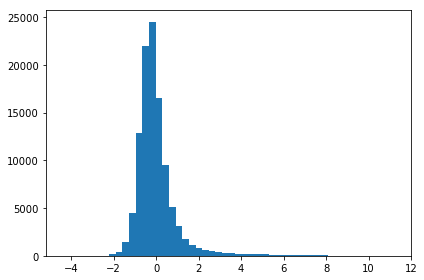

In [27]:
def process_data(train, valid, test, class_index, method=1, significance=3):
    
    def normalize_data(data, method):
        if method == 0:
            # standard-normal transformation
            mu = np.mean(data)
            sigma = np.std(data)
            data_norm = (data-mu)/sigma      
            params = [mu, sigma]
        elif method == 1:
            # log-standard-normal transformation
            MIN = np.min(data)
            data = np.log(data-MIN+1)
            mu = np.mean(data)
            sigma = np.std(data)
            data_norm = (data-mu)/sigma      
            params = [MIN, mu, sigma]
        elif method == 2:    
            MIN = np.min(data)
            data,_ = stats.boxcox(data - MIN + 10)#, lmbda=.5)
            mu = np.mean(data)
            sigma = np.std(data)
            data_norm = (data-mu)/sigma      
            params = [MIN, mu, sigma]
            #data_norm[data_norm<0] = 0
        return data_norm, params

    def clip_data(data, significance, method):
        std = np.std(data)
        if method == 0:
            index = np.where(data > std*significance*6)[0]
            data[index] = std*significance*5
        index = np.where((data > -std*significance))[0]
        data = data[index]
        return data, index
        
    #Y_train = train[1][:,class_index]
    #Y_valid = valid[1][:,class_index]
    #Y_test = test[1][:,class_index]

    Y_train = np.expand_dims(train[1][:,class_index],axis=1)
    Y_valid = np.expand_dims(valid[1][:,class_index],axis=1)
    Y_test = np.expand_dims(test[1][:,class_index],axis=1)
    
    train_index = np.where(np.isnan(Y_train) == False)[0]
    valid_index = np.where(np.isnan(Y_valid) == False)[0]
    test_index = np.where(np.isnan(Y_test) == False)[0]

    Y_train, params_train = normalize_data(Y_train[train_index], method)                 
    Y_valid, params_valid = normalize_data(Y_valid[valid_index], method)                 
    Y_test, params_test = normalize_data(Y_test[test_index], method)                 
    X_train = train[0][train_index]
    X_valid = valid[0][valid_index]
    X_test = test[0][test_index]
                         
    if significance > 0:                     
        Y_train, train_index = clip_data(Y_train, significance, method)
        Y_valid, valid_index = clip_data(Y_valid, significance, method)
        Y_test, test_index = clip_data(Y_test, significance, method)
        X_train = X_train[train_index]
        X_valid = X_valid[valid_index]
        X_test = X_test[test_index]

    train = (X_train, Y_train)
    valid = (X_valid, Y_valid)
    test = (X_test, Y_test)

    return train, valid, test, params_train, params_valid, params_test
                     
              
# RBM28 = 189
# RBFOX1 = 69
# PUM = 1
# 83 = ASD-1
# MBNL = 178
# srsf7 = 216
# HUR = 17
# 181
class_index = 69
train, valid, test, params_train, params_valid, params_test = \
        process_data(train_all, valid_all, test_all, class_index=class_index, method=1, significance=0)

    
num_train, dim, seq_length, other = train[0].shape
input_shape = (None, dim, seq_length, other)
output_shape = train[1].shape

plt.hist(train[1],bins=50);

In [28]:
def model(input_shape, output_shape):

    # create model
    layer1 = {'layer': 'input', #41
            'input_shape': input_shape
            }
    layer2 = {'layer': 'conv1d', 
            'num_filters': 32, 
            'filter_size': 21, # 21
            'norm': 'batch',
            'activation': 'leaky_relu',
            'dropout': 0.1,
            'padding': 'VALID',
            'mean_poolsize': 7,   # 3
            }
    layer3 = {'layer': 'conv1d', 
            'num_filters': 64,
            'filter_size': 3, # 1
            'norm': 'batch',
            'activation': 'leaky_relu',
            'dropout': 0.5,
            'padding': 'VALID'
            }
    layer4 = {'layer': 'dense', 
            'num_units': output_shape[1],
            'activation': 'linear'
            }

    #from tfomics import build_network
    model_layers = [layer1, layer2, layer3, layer4]
    
    # optimization parameters
    optimization = {"objective": "squared_error",
                  "optimizer": "adam",
                  "learning_rate": 0.001, 
                  "l2": 1e-6,
                  #"l1": 0.1, 
                  }
    return model_layers, optimization


# get shapes
num_data, height, width, dim = train[0].shape
input_shape=[None, height, width, dim]
output_shape = train[1].shape

model_layers, optimization = model(input_shape, output_shape)

In [29]:
# set output file paths
results_path = utils.make_directory(data_path, 'results')
results_path = utils.make_directory(results_path, 'tfomics')
output_name = 'test'
filepath = os.path.join(results_path, output_name)

# build neural network class
nnmodel = nn.NeuralNet()
nnmodel.build_layers(model_layers, optimization)
nnmodel.inspect_layers()

# compile neural trainer
nntrainer = nn.NeuralTrainer(nnmodel, save='best', filepath=filepath)

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 41, 1, 4)
layer2: conv1d_0
(?, 21, 1, 32)
layer3: conv1d_0_batch
(?, 21, 1, 32)
layer4: conv1d_0_active
(?, 21, 1, 32)
layer5: conv1d_0_dropout
(?, 21, 1, 32)
layer6: conv1d_1
(?, 19, 1, 64)
layer7: conv1d_1_batch
(?, 19, 1, 64)
layer8: conv1d_1_active
(?, 19, 1, 64)
layer9: conv1d_1_dropout
(?, 19, 1, 64)
layer10: dense_0
(?, 1)
layer11: dense_0_bias
(?, 1)
layer12: output
(?, 1)
----------------------------------------------------------------------------


In [30]:
sess = utils.initialize_session(nnmodel.placeholders)

In [31]:
train_batch = {'inputs': train[0], 'targets': train[1]}
valid_batch = {'inputs': valid[0], 'targets': valid[1]}
#test = {'inputs': X_test, 'targets': y_test}
data = {'train': train_batch, 'valid': valid_batch}
fit.train_minibatch(sess, nntrainer, data, batch_size=100, num_epochs=50, 
                      patience=20, verbose=2, shuffle=True, save_all=False)

Epoch 1 out of 50 
[==============================] 100.0% -- time=0s -- loss=1.12862 -- correlation=1.12842   
  valid loss:		0.88512
  valid Pearson's R:	0.36572+/-0.00000
  valid rsquare:	0.11488+/-0.00000
  valid slope:		0.98841+/-0.00000
  lower cross-validation found
  saving model to:  /media/peter/storage/DeepBind/rnac/results/tfomics/test_best.ckpt
Epoch 2 out of 50 
[==============================] 100.0% -- time=0s -- loss=0.89397 -- correlation=0.89378   
  valid loss:		0.80664
  valid Pearson's R:	0.44319+/-0.00000
  valid rsquare:	0.19499+/-0.00000
  valid slope:		1.09971+/-0.00000
  lower cross-validation found
  saving model to:  /media/peter/storage/DeepBind/rnac/results/tfomics/test_best.ckpt
Epoch 3 out of 50 
[==============================] 100.0% -- time=0s -- loss=0.82978 -- correlation=0.82958   
  valid loss:		0.76500
  valid Pearson's R:	0.49159+/-0.00000
  valid rsquare:	0.23894+/-0.00000
  valid slope:		1.14644+/-0.00000
  lower cross-validation found
  savi

In [21]:
nntrainer.set_best_parameters(sess)

test = {'inputs': test_sequence, 'targets': norm_test_targets}
loss, mean_vals, std_vals = nntrainer.test_model(sess, test, batch_size=128, name='test', verbose=1)

loading model from:  /Users/praveenanand/Documents/LabNoteBook/Peter_DeepNeural_RNABinding/Datasets/DeepBind/nbt3300-code/data/rnac/results/tfomics/test_best.ckpt
  test  loss:		0.50177
  test  Pearson's R:	0.70834+/-0.00000
  test  rsquare:	0.50175+/-0.00000
  test  slope:		0.93215+/-0.00000


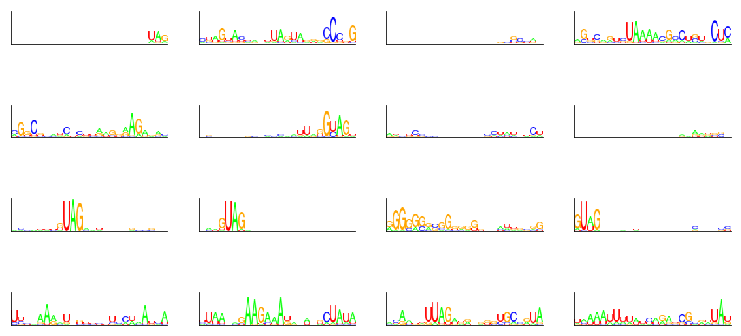

In [22]:
W = nnmodel.get_parameters(sess, layer='conv1d_0')[0]
W = np.squeeze(W.transpose([3, 2, 0, 1]))
fig, plt = visualize.plot_filter_logos(W, normalize=True, figsize=(100,50), height=25, 
                            nt_width=10, norm=0, alphabet='rna')

In [23]:
predictions = nntrainer.get_activations(sess, test, layer='output')

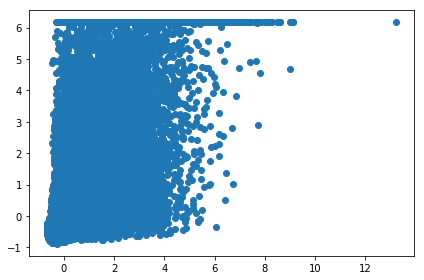

In [24]:
plt.scatter(predictions, norm_test_targets)

In [25]:
max_indices = np.argsort(predictions[:,0])[::-1]
predictions[max_indices]

array([[ 13.23156357],
       [  9.11865997],
       [  9.11865997],
       ..., 
       [ -0.66619956],
       [ -0.67033774],
       [ -0.67811853]], dtype=float32)

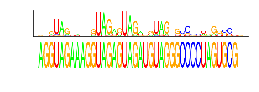

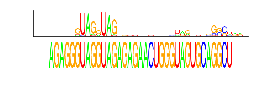

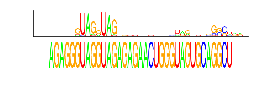

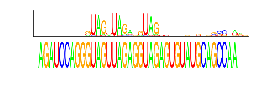

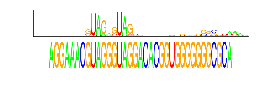

In [26]:
num_plots = 5

for i, index in enumerate(max_indices[:5]):
    # sequence to perform saliency analysis
    
    X = np.expand_dims(test_sequence[index], axis=0)

    # parameters for saliency analysis
    params = {'genome_model': model, 
              'input_shape': input_shape, 
              'output_shape': output_shape, 
              'model_path': filepath+'_best.ckpt',
              'optimization': optimization
             }

    # guided backprop saliency
    #guided_saliency = saliency.guided_backprop(X, layer='output', class_index=0, params=params)

    # stochastic guided backprop saliency
    guided_saliency = saliency.stochastic_guided_backprop(X, layer='output', class_index=None, params=params,
                                                             num_average=200, threshold=0.0, stochastic_val=0.5)


    # plot saliency comparison
    plt.figure()
    visualize.plot_seq_pos_saliency(np.squeeze(X).T, np.squeeze(guided_saliency[0]).T, alphabet='rna')    
    

(-0.5, 819.5, 99.5, -0.5)

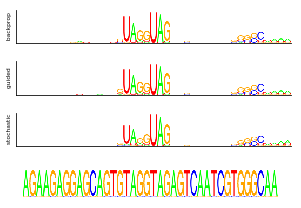

In [52]:

# sequence to perform saliency analysis
X = np.expand_dims(test_sequence[index], axis=0)

# parameters for saliency analysis
params = {'genome_model': model, 
          'input_shape': input_shape, 
          'output_shape': output_shape, 
          'model_path': filepath+'_best.ckpt',
          'optimization': optimization
         }

# backprop saliency
backprop_saliency = saliency.backprop(X, layer='output', class_index=0, params=params)

# guided backprop saliency
guided_saliency = saliency.guided_backprop(X, layer='output', class_index=0, params=params)

# stochastic guided backprop saliency
stochastic_saliency = saliency.stochastic_guided_backprop(X, layer='output', class_index=0, params=params,
                                                         num_average=200, threshold=12.0, stochastic_val=0.5)

# plot saliency comparison
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=True, figsize=(15, 3));
plt.subplot(4,1,1)
visualize.plot_pos_saliency(np.squeeze(backprop_saliency[0]).T, alphabet='rna')    
plt.ylabel(' backprop', fontsize=6)
plt.subplot(4,1,2)
visualize.plot_pos_saliency(np.squeeze(guided_saliency[0]).T, alphabet='rna')    
plt.ylabel(' guided', fontsize=6)
plt.subplot(4,1,3)
visualize.plot_pos_saliency(np.squeeze(stochastic_saliency[0]).T, alphabet='rna')    
plt.ylabel(' stochastic', fontsize=6)
plt.subplot(4,1,4)
visualize.plot_pos_saliency(np.squeeze(X).T, alphabet='rna')    
plt.axis('off')